In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

In [2]:
epoch = np.datetime64('1970-01-01T00:00:00')

In [3]:
ds = xr.open_dataset('data/processed/stream-coarse-pd4-1.nc')
ds_range = xr.open_dataset('data/processed/range-pd-sync3-1.nc')

In [4]:
sample_time = ds.time.values
upsample_time = ds_range.time.values

In [5]:
sample_secs = (sample_time-epoch)/1e9 
sample_secs = sample_secs.astype('float64')

upsample_secs = (upsample_time-epoch)/1e9 
upsample_secs = upsample_secs.astype('float64')

In [8]:
def interp(sample_secs,upsample_secs,latitude,longitude,pd):
    '''
    
    '''
    
    inter_pd = np.zeros((len(upsample_secs),len(latitude),len(longitude)))
    inter_pd[:] = np.nan
    
    for j, lat in enumerate(latitude):
        for k, long in enumerate(longitude):
            if np.isnan(pd[0,0,j,k]) == True:
                pass
            
            elif pd[0,0,j,k] == -5:
                inter_pd[:,j,k] = -5
                
            else:
                spline = PchipInterpolator(sample_secs,pd[:,0,j,k])
                interpolated = spline(upsample_secs)
                assert np.all(interpolated>=0)
                inter_pd[:,j,k] = interpolated
                
    return inter_pd

In [9]:
inter_pd = interp(sample_secs,upsample_secs,ds.lat.values,ds.lon.values,ds.pd.values)

In [15]:
data_xr = xr.Dataset({
    'pd': xr.DataArray(
        data=inter_pd,
        coords={'time': upsample_time,
                'lat': ds.lat.values,
                'lon': ds.lon.values},
        dims=['time','lat','lon'])})
        

data_xr['pd'] = data_xr.pd.assign_attrs(units='$Wm^{-2}$')
data_xr['pd'] = data_xr.pd.assign_attrs(long_name='power density')
data_xr['lat'] = data_xr.lat.assign_attrs(units='degrees')
data_xr['lat'] = data_xr.lat.assign_attrs(long_name='latitude')
data_xr['lon'] = data_xr.lon.assign_attrs(units='degrees')
data_xr['lon'] = data_xr.lon.assign_attrs(long_name='longitude')

        
data_xr.to_netcdf(path=f'data/processed/stream-pd-int2.nc')

In [16]:
ds = xr.open_dataset('data/processed/stream-pd-int2.nc')

In [17]:
ds

<xarray.Dataset>
Dimensions:  (time: 2688, lat: 519, lon: 232)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-02 ... 2020-01-29T23:45:00
  * lat      (lat) float32 48.0 48.03 48.05 48.08 ... 61.92 61.95 61.97 62.0
  * lon      (lon) float32 -10.0 -9.939 -9.879 -9.818 ... 3.818 3.879 3.939 4.0
Data variables:
    pd       (time, lat, lon) float64 ...

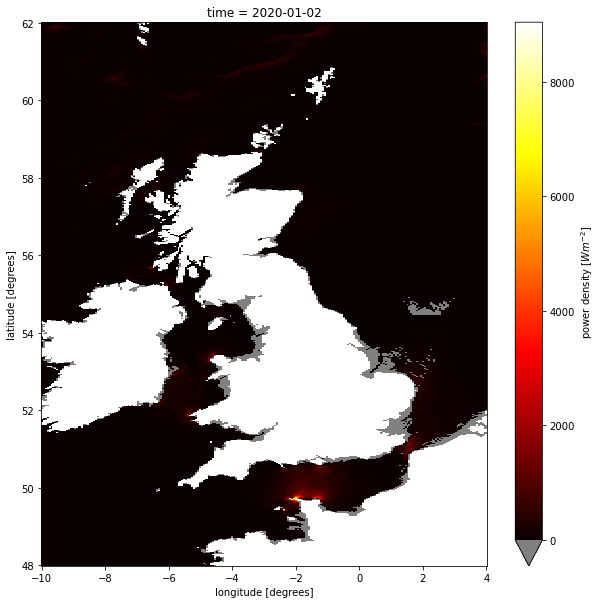

In [18]:
cmap = mpl.cm.get_cmap('hot').copy()
cmap.set_under('gray')

target_time = '2020-01-02T00:00:00.000000000' 
ds.pd.sel(time=target_time,method='nearest').plot(size=10,aspect=1,vmin=0,cmap=cmap)  

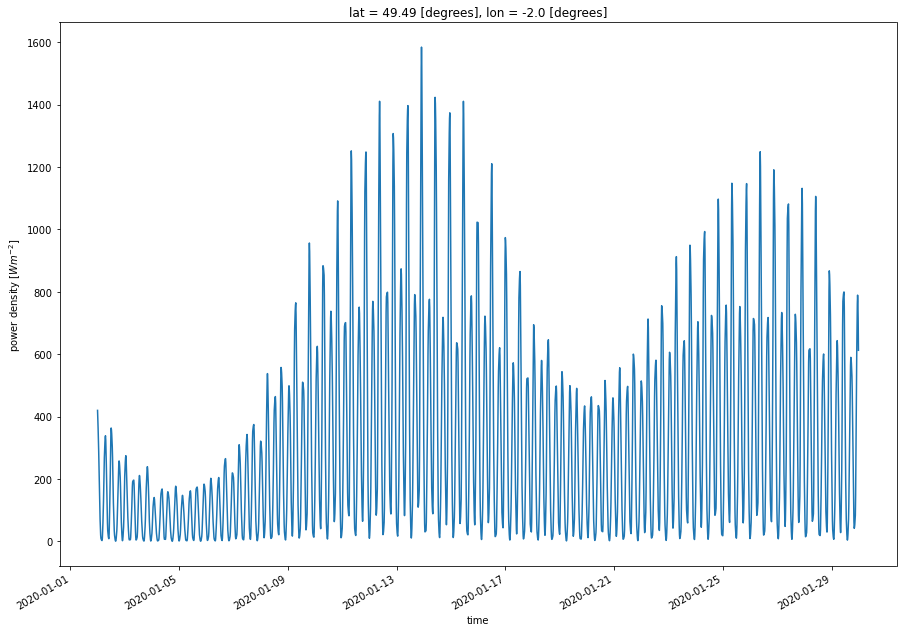

In [19]:
long = -2
lat = 49.5

ds.pd.sel(lon=long,lat=lat,method='nearest').plot(size=10)